# Demo for how to perform "the ultimate fit" when tracking capillaries. In the ultimate fit, several (below we fit two profiles) line-profiles are fitted in time simultaneously.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../../sl2pm')

import track_vessel_A, track_vessel_B, track_vessel_C
from models import L_multi, L_multi_plasma, L_multi_wall
import misc

## Protocol A: The Ultimate Fit (both plasma and wall fluorescence)

In [2]:
kymo_wall = np.load('wall.npy')
kymo_plasma = np.load('plasma.npy')

nt, nx = kymo_wall.shape
x = np.arange(nx)

kymo_wall = kymo_wall.reshape((2, nt//2, nx)).mean(axis=1)
kymo_plasma = kymo_plasma.reshape((2, nt//2, nx)).mean(axis=1)

N_AVER = nt//2

## Enter PMT parameters (known from the calibration)

In [3]:
ALPHA = 0.452
SIGMA = 6.0
GAIN = 3/ALPHA

## Make an initial parameter guess

In [4]:
p0_A = track_vessel_A.p0_ols_ultimate(kymo_wall, kymo_plasma, ALPHA, sigma_blur=1.5)

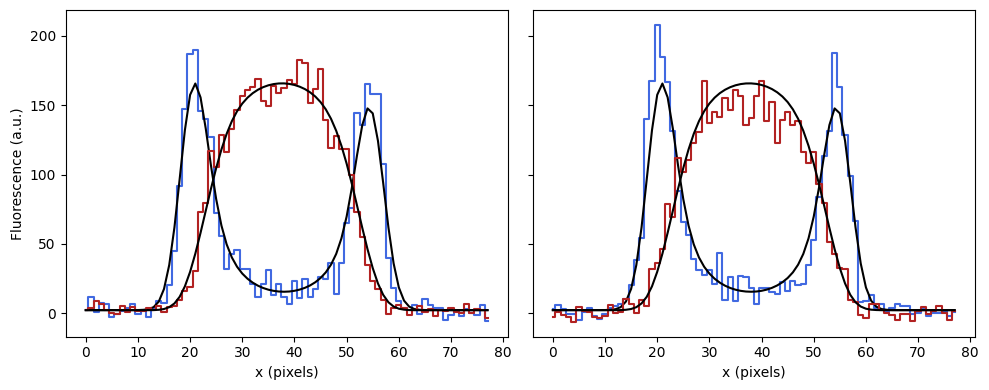

In [5]:
[[w1_A0, p1_A0], [w2_A0, p2_A0]] = L_multi(x, *p0_A)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0], where='mid', c='royalblue')
ax1.plot(x, w1_A0*GAIN, c='k')

ax1.step(x, kymo_plasma[0], where='mid', c='firebrick')
ax1.plot(x, p1_A0*GAIN, c='k')

# Second time point
ax2.step(x, kymo_wall[1], where='mid', c='royalblue')
ax2.plot(x, w2_A0*GAIN, c='k')

ax2.step(x, kymo_plasma[1], where='mid', c='firebrick')
ax2.plot(x, p2_A0*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

## Fit

In [6]:
opt_res_A = track_vessel_A.mle_fit_ultimate(kymo_wall, kymo_plasma, N_AVER, ALPHA, SIGMA, n_r=256, n_phi=256, p0='ols', sigma_blur=1, minimize_options=dict(gtol=1e-3))
opt_res_A

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1148.29235402235
        x: [ 2.107e+00  8.068e+00 ... -6.132e-02 -1.080e-01]
      nit: 51
      jac: [-2.289e-04 -3.052e-05 ... -3.510e-04  8.240e-04]
 hess_inv: [[ 1.113e-03 -3.391e-03 ... -4.572e-05  1.281e-04]
            [-3.391e-03  7.441e-02 ...  8.518e-06 -2.453e-04]
            ...
            [-4.572e-05  8.518e-06 ...  1.480e-04 -3.721e-05]
            [ 1.281e-04 -2.453e-04 ... -3.721e-05  2.268e-04]]
     nfev: 1116
     njev: 62

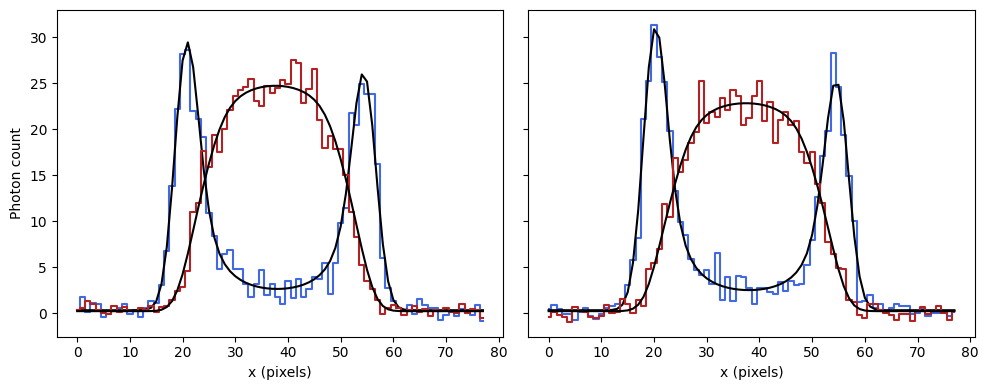

In [7]:
[[w1_A, p1_A], [w2_A, p2_A]] = L_multi(x, *opt_res_A.x)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0]/GAIN, where='mid', c='royalblue')
ax1.plot(x, w1_A, c='k')

ax1.step(x, kymo_plasma[0]/GAIN, where='mid', c='firebrick')
ax1.plot(x, p1_A, c='k')

# Second time point
ax2.step(x, kymo_wall[1]/GAIN, where='mid', c='royalblue')
ax2.plot(x, w2_A, c='k')

ax2.step(x, kymo_plasma[1]/GAIN, where='mid', c='firebrick')
ax2.plot(x, p2_A, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Photon count')

plt.tight_layout()

In [8]:
misc.fitted_params(opt_res_A, ['s_xy', 'l', 'dR', 's_gcx', 'b_plasma', 'b_tissue_wall', 'b_tissue_plasma', 'Iw1', 'Iw2', 'Ip1', 'Ip2', 'R_w1', 'R_w2', 'xc1', 'xc2', 'a1_1', 'a1_2'])

{'s_xy': (2.107118972090433, 0.03336761901185355),
 'l': (8.067835817178047, 0.27277320453751636),
 'dR': (6.138286027136043, 0.7062080759299965),
 's_gcx': (6.966009254446444, 1.5479834403969055),
 'b_plasma': (-0.33343185265472436, 0.2060637293504067),
 'b_tissue_wall': (0.33543892057294844, 0.05255543607326975),
 'b_tissue_plasma': (0.23299806243216384, 0.04768850951842593),
 'Iw1': (201.99659092115604, 2.9397889595569042),
 'Iw2': (203.58100281259675, 3.009378550387182),
 'Ip1': (29.211723178928903, 0.38943171120759934),
 'Ip2': (26.735158202380195, 0.37427982686506395),
 'R_w1': (17.559829963242176, 0.04439463822817491),
 'R_w2': (17.949176838707807, 0.04528893019759777),
 'xc1': (37.616604554822395, 0.0347010648422234),
 'xc2': (37.42888478606044, 0.034454180533530464),
 'a1_1': (-0.06131823619966245, 0.012167422448377097),
 'a1_2': (-0.10796661547251832, 0.015060896780482134)}

***

## Protocol B: The Ultimate Fit (only plasma fluorescence)

In [9]:
kymo_plasma = np.load('plasma.npy')

nt, nx = kymo_plasma.shape
x = np.arange(nx)

kymo_plasma = kymo_plasma.reshape((2, nt//2, nx)).mean(axis=1)

N_AVER = nt//2

## Enter PMT parameters (known from the calibration)

In [10]:
ALPHA = 0.452
SIGMA = 6.0
GAIN = 3/ALPHA

## Make an initial parameter guess

In [11]:
p0_B = track_vessel_B.p0_ols_ultimate(kymo_plasma, ALPHA, sigma_blur=1.5)

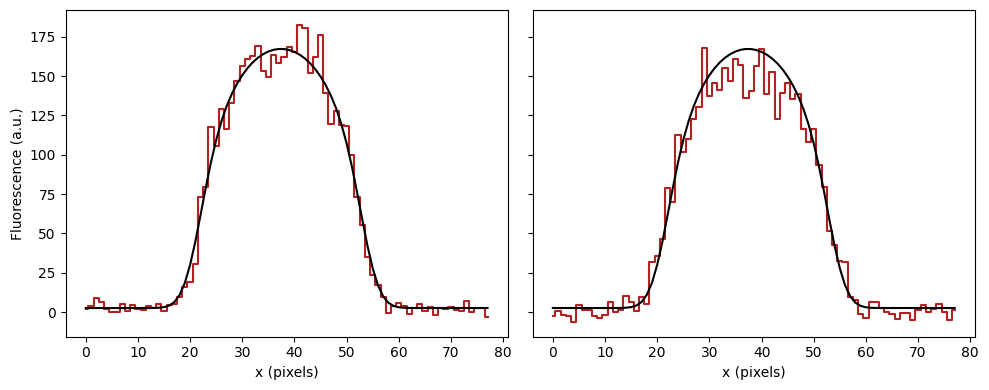

In [12]:
p1_B0, p2_B0 = L_multi_plasma(x, *p0_B)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_plasma[0], where='mid', c='firebrick')
ax1.plot(x, p1_B0*GAIN, c='k')

# Second time point
ax2.step(x, kymo_plasma[1], where='mid', c='firebrick')
ax2.plot(x, p2_B0*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

## Fit

In [13]:
opt_res_B = track_vessel_B.mle_fit_ultimate(kymo_plasma, N_AVER, ALPHA, SIGMA, n_r=256, p0='ols', sigma_blur=1, minimize_options=dict(gtol=1e-4))
opt_res_B

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 525.9610675795783
        x: [-2.434e+00  2.978e+01  2.375e-01  5.989e+01  5.222e+01
             1.639e+01  1.723e+01  3.740e+01  3.732e+01]
      nit: 64
      jac: [ 3.052e-05 -7.629e-06  3.815e-05  1.526e-05  0.000e+00
             6.866e-05  4.578e-05  7.629e-06 -1.526e-05]
 hess_inv: [[ 1.323e-02  4.899e-02 ...  3.005e-04  1.993e-04]
            [ 4.899e-02  5.309e+00 ... -2.856e-04 -5.347e-03]
            ...
            [ 3.005e-04 -2.856e-04 ...  6.088e-03  6.942e-05]
            [ 1.993e-04 -5.347e-03 ...  6.942e-05  6.410e-03]]
     nfev: 840
     njev: 84

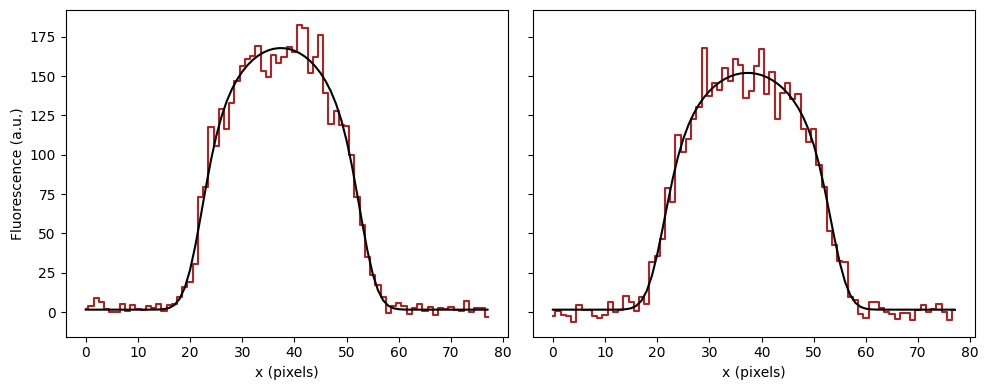

In [14]:
p1_B, p2_B = L_multi_plasma(x, *opt_res_B.x)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_plasma[0], where='mid', c='firebrick')
ax1.plot(x, p1_B*GAIN, c='k')

# Second time point
ax2.step(x, kymo_plasma[1], where='mid', c='firebrick')
ax2.plot(x, p2_B*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

In [15]:
misc.fitted_params(opt_res_B, ['s_xy', 'l', 'b', 'I1', 'I2', 'R1', 'R2', 'xc1', 'xc2'])

{'s_xy': (-2.433914069489488, 0.11502798934289227),
 'l': (29.78447941797668, 2.304090361901797),
 'b': (0.23748094246620144, 0.04905718340745755),
 'I1': (59.893369842724866, 3.3377279698987734),
 'I2': (52.21602441534367, 2.967777083264923),
 'R1': (16.393593233714387, 0.1010186980198251),
 'R2': (17.232115873931644, 0.11387119224680081),
 'xc1': (37.39772543348468, 0.07802471019374776),
 'xc2': (37.31666001200057, 0.08006429902065762)}

***

## Protocol C: The Ultimate Fit (only wall fluorescence)

In [16]:
kymo_wall = np.load('wall.npy')

nt, nx = kymo_wall.shape
x = np.arange(nx)

kymo_wall = kymo_wall.reshape((2, nt//2, nx)).mean(axis=1)

N_AVER = nt//2

## Enter PMT parameters (known from the calibration)

In [17]:
ALPHA = 0.452
SIGMA = 6.0
GAIN = 3/ALPHA

## Make an initial parameter guess

In [18]:
p0_C = track_vessel_C.p0_ols_ultimate(kymo_wall, ALPHA, sigma_blur=1.5)

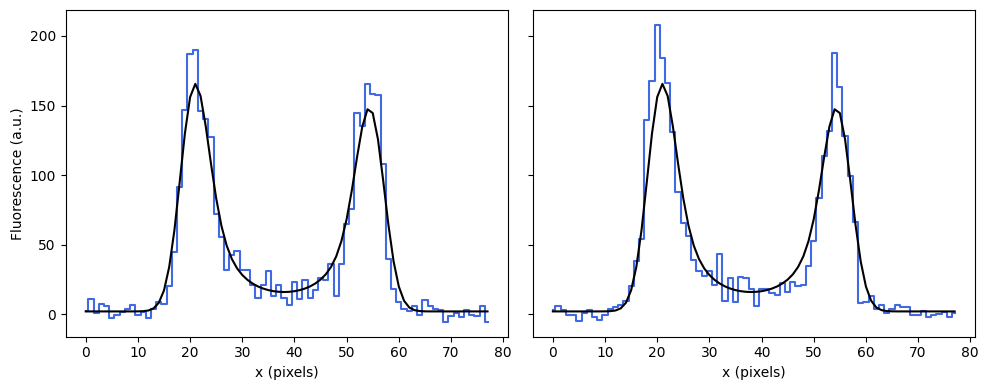

In [19]:
w1_C0, w2_C0 = L_multi_wall(x, *p0_C)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0], where='mid', c='royalblue')
ax1.plot(x, w1_C0*GAIN, c='k')

# Second time point
ax2.step(x, kymo_wall[1], where='mid', c='royalblue')
ax2.plot(x, w2_C0*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

## Fit

In [20]:
opt_res_C = track_vessel_C.mle_fit_ultimate(kymo_wall, N_AVER, ALPHA, SIGMA, n_r=256, p0='ols', sigma_blur=1, minimize_options=dict(gtol=1e-4))
opt_res_C

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 607.6660867892957
        x: [ 2.114e+00  7.820e+00 -1.498e-01  3.334e-01  1.992e+02
             2.008e+02  1.758e+01  1.791e+01  3.767e+01  3.745e+01
            -6.249e-02 -1.085e-01]
      nit: 34
      jac: [-6.866e-05 -2.289e-05 -7.629e-06 -1.526e-05  0.000e+00
             0.000e+00 -5.341e-05 -2.289e-05  7.629e-06 -7.629e-06
            -7.629e-06 -2.289e-05]
 hess_inv: [[ 1.672e-03 -2.725e-02 ...  9.937e-06 -4.906e-07]
            [-2.725e-02  8.530e-01 ... -2.164e-04  1.498e-04]
            ...
            [ 9.937e-06 -2.164e-04 ...  1.492e-04  8.237e-07]
            [-4.906e-07  1.498e-04 ...  8.237e-07  1.487e-04]]
     nfev: 546
     njev: 42

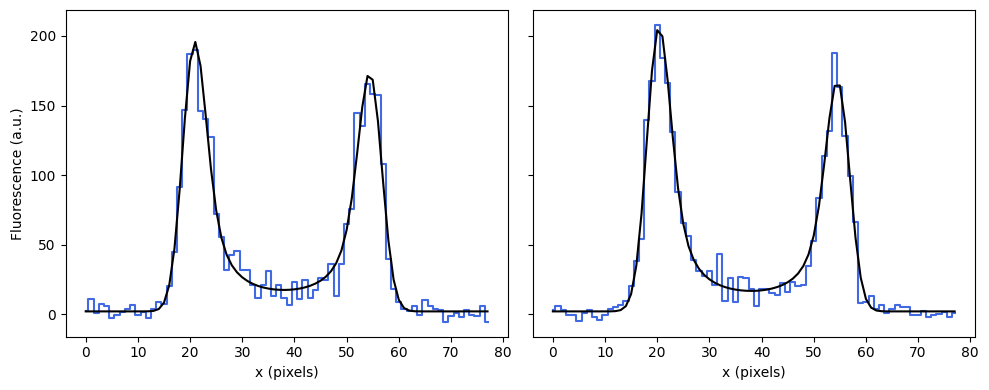

In [21]:
w1_C, w2_C = L_multi_wall(x, *opt_res_C.x)

fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

# First time point
ax1.step(x, kymo_wall[0], where='mid', c='royalblue')
ax1.plot(x, w1_C*GAIN, c='k')

# Second time point
ax2.step(x, kymo_wall[1], where='mid', c='royalblue')
ax2.plot(x, w2_C*GAIN, c='k')

ax1.set_xlabel('x (pixels)')
ax2.set_xlabel('x (pixels)')
ax1.set_ylabel('Fluorescence (a.u.)')

plt.tight_layout()

In [22]:
misc.fitted_params(opt_res_C, ['s_xy', 'l', 'b_plasma', 'b_tissue', 'Iw1', 'Iw2', 'R_w1', 'R_w2', 'xc1', 'xc2', 'a1_1', 'a1_2'])

{'s_xy': (2.114414857804028, 0.04088594414700216),
 'l': (7.820007000398463, 0.9235924615773743),
 'b_plasma': (-0.14977227040888377, 0.6679260687270732),
 'b_tissue': (0.33338797608144977, 0.05296389850990524),
 'Iw1': (199.23674163695023, 10.069408327195326),
 'Iw2': (200.77127171663912, 10.375803918042466),
 'R_w1': (17.58247185152007, 0.07123984361201435),
 'R_w2': (17.908774347250542, 0.07052076433558643),
 'xc1': (37.66982676621807, 0.03901687812579152),
 'xc2': (37.44938180217857, 0.03840066420194272),
 'a1_1': (-0.06249125650203159, 0.012213986755842655),
 'a1_2': (-0.10851095473905152, 0.012192315993365357)}